In [23]:
#Imports pandas, geopandas, and matplotlib
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import datetime as dt

#Creates neighborhoods GDF from GeoJSON
neighborhood_gdf = geopandas.read_file("neighborhoods.geojson").set_index('hood')

#Correcting for some oddities in neighborhoods data where sqmiles is plain wrong for select neighborhoods
neighborhood_gdf.at['Perry North','sqmiles'] = 1.212
neighborhood_gdf.at['Lincoln-Lemington-Belmar','sqmiles'] = 1.812
neighborhood_gdf.at['Marshall-Shadeland','sqmiles'] = 1.254

#Reads Dom's arrest csv and filters by years
arrest = pd.read_csv("arrests.csv")
arrest_mask = (arrest["ARRESTTIME"].str[:4].astype('int') >= 2017) & (arrest["ARRESTTIME"].str[:4].astype('int') <= 2020)
arrest_4 = arrest[arrest_mask]

#Reads Alex's fire incidents csv and filters by years
fire_data = pd.read_csv("Fire_Alarm.csv").dropna(subset = ['neighborhood','alarm_time'])
fire_mask = (fire_data["alarm_time"].str[:4].astype('int') >= 2017) & (fire_data["alarm_time"].str[:4].astype('int') <= 2020)
fire_4 = fire_data[fire_mask]

#Reads Sean's crashes csv and filters by years
crashes_df = pd.read_csv("crashes.csv", low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])
crashes_mask = (crashes_df['CRASH_YEAR'] >= 2017) & (crashes_df['CRASH_YEAR'] <= 2020)
crashes_4 = crashes_df[crashes_mask]
crashes_gdf = geopandas.GeoDataFrame(crashes_4, geometry=geopandas.points_from_xy(crashes_4.DEC_LONG, crashes_4.DEC_LAT, crs=4326))

,sqmiles,arrests,arrests_sqmile
hood,,,
East Allegheny,0.236,1366.0,5788.135593
Central Business District,0.640,2614.0,4084.375000
Allegheny Center,0.210,771.0,3671.428571
Homewood South,0.398,1409.0,3540.201005
Homewood North,0.434,1288.0,2967.741935


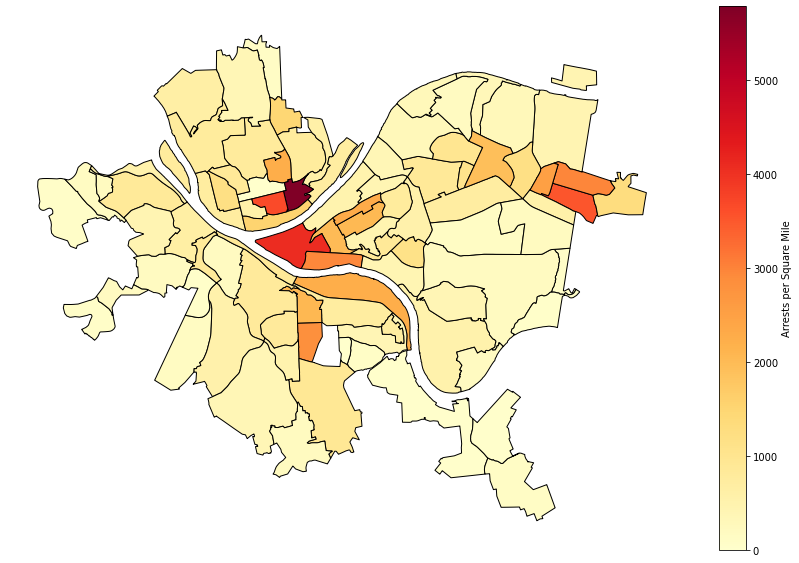

In [31]:
#Adds 'arrests' and 'arrests_sqmile' columns to neighborhood_gdf
filterarrest = arrest_4.groupby("INCIDENTNEIGHBORHOOD")["OFFENSES"].count()
filterarrest=filterarrest.rename(index={'Mt. Oliver Neighborhood':'Mt. Oliver'})
try:
    neighborhood_gdf.insert(0, "arrests", filterarrest)
except ValueError:
    neighborhood_gdf['arrests'] = filterarrest
neighborhood_gdf['arrests'] = neighborhood_gdf['arrests'].fillna(0)
neighborhood_gdf = neighborhood_gdf.assign(arrests_sqmile = lambda x: x['arrests'] / x['sqmiles'])

neighborhood_gdf.plot(figsize=(15,10), column = "arrests_sqmile",
                    cmap = "YlOrRd",
                   legend = True,
                   legend_kwds = {"label":"Arrests per Square Mile"},
                   edgecolors = "black")
plt.axis("off")
neighborhood_gdf.sort_values('arrests_sqmile', ascending=False)[['sqmiles','arrests','arrests_sqmile']].head(5)

,sqmiles,fires,fires_sqmile
hood,,,
East Allegheny,0.236,53.0,224.576271
Knoxville,0.302,65.0,215.231788
Central Northside,0.259,44.0,169.884170
Bluff,0.327,51.0,155.963303
Homewood North,0.434,59.0,135.944700


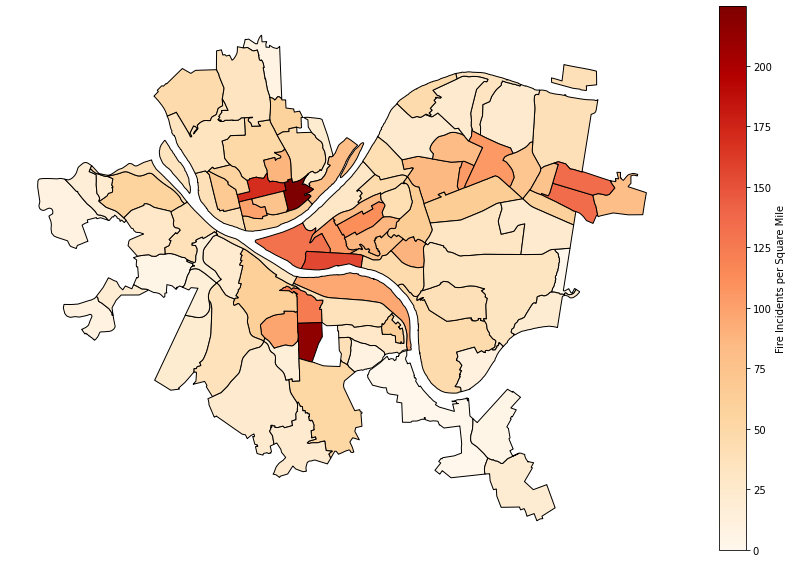

In [25]:
#Adds columns 'fires' and 'fires_sqmile' to neighborhood_gdf
neighborhood_fires = fire_4.groupby("neighborhood")["call_no"].count()
try:
    neighborhood_gdf.insert(0, "fires", neighborhood_fires)
except ValueError:
    neighborhood_gdf['fires'] = neighborhood_fires
neighborhood_gdf['fires'] = neighborhood_gdf['fires'].fillna(0)
neighborhood_gdf = neighborhood_gdf.assign(fires_sqmile = lambda x: x['fires'] / x['sqmiles'])

neighborhood_gdf.plot(column='fires_sqmile',
              cmap='OrRd',
              edgecolor="black",      
              legend=True,              
              legend_kwds={'label': "Fire Incidents per Square Mile"}, 
              figsize=(15, 10),         
              )
plt.axis("off")
neighborhood_gdf.sort_values('fires_sqmile', ascending=False)[['sqmiles','fires','fires_sqmile']].head(5)

,sqmiles,crashes,crashes_sqmile
hood,,,
Bluff,0.327,504,1541.284404
Central Business District,0.640,913,1426.562500
East Allegheny,0.236,300,1271.186441
South Shore,0.212,242,1141.509434
West End,0.200,207,1035.000000


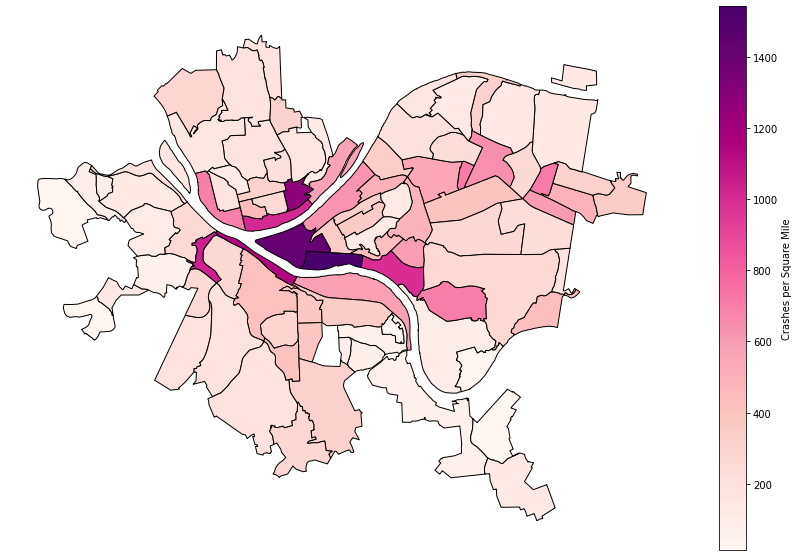

In [26]:
#Adds columns 'crashes' and 'crashes_sqmile' to neighborhood_gdf
crash_count = pd.Series(index=neighborhood_gdf.index, data=0, dtype=int)
for i in neighborhood_gdf.index:
    bool_crashes = crashes_gdf.within(neighborhood_gdf.loc[i].geometry)
    try:
        crash_count[i] = bool_crashes.value_counts().loc[True]
    except KeyError:
        continue
try:
    neighborhood_gdf.insert(1, "crashes", crash_count)
except ValueError:
    neighborhood_gdf['crashes'] = crash_count
neighborhood_gdf = neighborhood_gdf.assign(crashes_sqmile = lambda x: x['crashes'] / x['sqmiles'])

neighborhood_gdf.plot(column='crashes_sqmile',
                      cmap="RdPu",
                      edgecolor="black",   
                      legend=True,
                      legend_kwds={'label':'Crashes per Square Mile'},
                      figsize=(15,10))
plt.axis('off')
neighborhood_gdf.sort_values('crashes_sqmile', ascending=False)[['sqmiles','crashes','crashes_sqmile']].head(5)

,sqmiles,arrests,fires,crashes,arrests_sqmile,fires_sqmile,crashes_sqmile,score
hood,,,,,,,,
East Allegheny,0.236,1366.0,53.0,300,5788.135593,224.576271,1271.186441,94.158596
Central Business District,0.640,2614.0,84.0,913,4084.375000,131.250000,1426.562500,73.854912
Bluff,0.327,963.0,51.0,504,2944.954128,155.963303,1541.284404,73.442320
Knoxville,0.302,857.0,65.0,117,2837.748344,215.231788,387.417219,56.667348
Homewood South,0.398,1409.0,54.0,196,3540.201005,135.678392,492.462312,51.176590


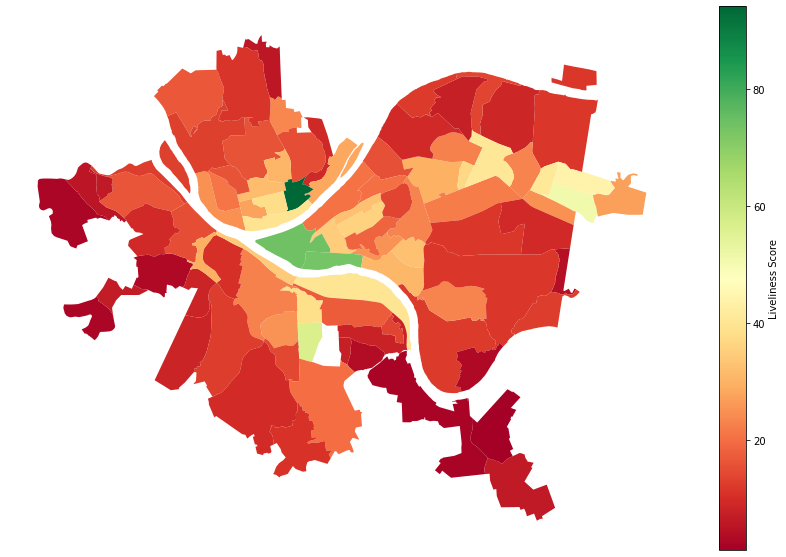

In [27]:
max_series = neighborhood_gdf[['arrests_sqmile','fires_sqmile','crashes_sqmile']].max()
neighborhood_gdf = neighborhood_gdf.assign(arrests_1 = lambda x: x['arrests_sqmile'] / max_series['arrests_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(fires_1 = lambda x: x['fires_sqmile'] / max_series['fires_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(crashes_1 = lambda x: x['crashes_sqmile'] / max_series['crashes_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(score = lambda x: (x['arrests_1'] + x['fires_1'] + x['crashes_1']) / 3 * 100)

neighborhood_gdf.plot(column='score',
                      cmap="RdYlGn",
                      legend=True,
                      legend_kwds={'label':'Liveliness Score'},
                      figsize=(15,10))
plt.axis('off')
neighborhood_gdf.sort_values('score', ascending=False)[['sqmiles','arrests','fires','crashes','arrests_sqmile', 'fires_sqmile','crashes_sqmile','score']].head(5)